In [11]:
import torch as ptorch
import torchvision as tvision
import numpy as numpy
import cv2 as cv
import sklearn as sklearn
import pandas as pandas
import matplotlib as matplot
import tqdm as tqdm
import tensorflow as tf
import albumentations as A
import seaborn as sns
import matplotlib.pyplot as plt
import keras as keras






In [12]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

# Define where your main dataset folder is
# (Assuming a structure like: ./my_dataset/real/ and ./my_dataset/fake/...)
data_directory = '/Users/dimashmadiyar/Documents/GitHub/HackPrinceton25/data' 

# Define parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
SEED = 42
VALIDATION_SPLIT = 0.2 # 20% for testing/validation

# 1. Create a data generator instance
# We only need rescaling (normalization) for simple loading
datagen = ImageDataGenerator(rescale=1./255, validation_split=VALIDATION_SPLIT)

# 2. Load and split the training data
train_generator = datagen.flow_from_directory(
    data_directory,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',       # Because you have 'real' and 'fake' classes
    subset='training',         # Specify training subset
    seed=SEED                  # For reproducible results
)

# 3. Load the testing/validation data
validation_generator = datagen.flow_from_directory(
    data_directory,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',       # Specify validation subset
    seed=SEED
)

# You can now use train_generator and validation_generator
# directly to train your deep learning model:
# model.fit(train_generator, validation_data=validation_generator, ...)


Found 2795 images belonging to 3 classes.
Found 697 images belonging to 3 classes.


In [13]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define your model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flatten the 3D output to 1D for the Dense layers
    Flatten(),
    
    # Fully Connected Layers
    Dense(512, activation='relu'),
    Dropout(0.5), # Optional: helps prevent overfitting
    
    # Output layer for binary classification ('real' vs 'fake')
    # Use 'sigmoid' activation for binary output
    Dense(1, activation='sigmoid') 
])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(
    loss='binary_crossentropy', # Standard loss for binary classification
    optimizer='adam',           # A good general-purpose optimizer
    metrics=['accuracy']        # Track classification accuracy
)

# Optional: Print a summary of the model structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
EPOCHS = 15 # Number of times to iterate over the entire dataset

# Calculate steps per epoch based on your batch size and total number of samples
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step - accuracy: 0.7629 - loss: 0.4563 - val_accuracy: 0.6994 - val_loss: 1.4035
Epoch 2/15
 1/87 ━━━━━━━━━━━━━━━━━━━━ 30s 351ms/step - accuracy: 0.9062 - loss: 0.2482

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9062 - loss: 0.2482 - val_accuracy: 0.6935 - val_loss: 1.2558
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step - accuracy: 0.8849 - loss: 0.2543 - val_accuracy: 0.6577 - val_loss: 2.2519
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9062 - loss: 0.1805 - val_accuracy: 0.6682 - val_loss: 2.2200
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 282ms/step - accuracy: 0.9146 - loss: 0.1612 - val_accuracy: 0.6667 - val_loss: 3.3777
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 1.0000 - loss: 0.1020 - val_accuracy: 0.6741 - val_loss: 3.3301
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 279ms/step - accuracy: 0.9591 - loss: -0.0656 - val_accuracy: 0.5997 - val_loss: 15.3739
Epoch 8/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9062 - loss: 0.3584 - val_accuracy: 0.6131 - val_loss: 16.0919
Epoch 9/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step - accuracy: 0.9363 - loss: -0.0482 - val_accuracy: 0.6801 - 

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.6686 - loss: 211.9955
Validation Loss: 211.9955
Validation Accuracy: 66.86%


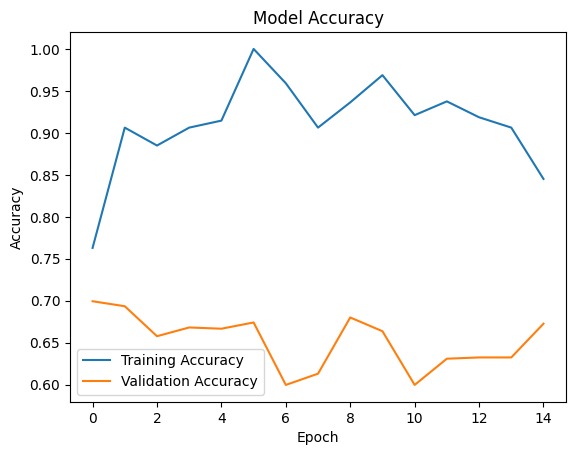

In [16]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")

# Optional: Plot training history to check for overfitting/underfitting
# (This requires matplotlib)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
model.save('ai_detector_model.h5')